In [2]:
import numpy as np
import albumentations as A
import json
import matplotlib.pyplot as plt
from PIL import Image

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [3]:
import os.path as osp
import math
import json
from PIL import Image

import torch
import numpy as np
import cv2
import albumentations as A
from torch.utils.data import Dataset
from shapely.geometry import Polygon
from numba import njit

@njit
def cal_distance(x1, y1, x2, y2):
    '''calculate the Euclidean distance'''
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

@njit
def move_points(vertices, index1, index2, r, coef):
    '''move the two points to shrink edge
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        index1  : offset of point1
        index2  : offset of point2
        r       : [r1, r2, r3, r4] in paper
        coef    : shrink ratio in paper
    Output:
        vertices: vertices where one edge has been shinked
    '''
    index1 = index1 % 4
    index2 = index2 % 4
    x1_index = index1 * 2 + 0
    y1_index = index1 * 2 + 1
    x2_index = index2 * 2 + 0
    y2_index = index2 * 2 + 1

    r1 = r[index1]
    r2 = r[index2]
    length_x = vertices[x1_index] - vertices[x2_index]
    length_y = vertices[y1_index] - vertices[y2_index]
    length = cal_distance(vertices[x1_index], vertices[y1_index], vertices[x2_index], vertices[y2_index])
    if length > 1:
        ratio = (r1 * coef) / length
        vertices[x1_index] += ratio * (-length_x)
        vertices[y1_index] += ratio * (-length_y)
        ratio = (r2 * coef) / length
        vertices[x2_index] += ratio * length_x
        vertices[y2_index] += ratio * length_y
    return vertices

@njit
def shrink_poly(vertices, coef=0.3):
    '''shrink the text region
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        coef    : shrink ratio in paper
    Output:
        v       : vertices of shrinked text region <numpy.ndarray, (8,)>
    '''
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    r1 = min(cal_distance(x1,y1,x2,y2), cal_distance(x1,y1,x4,y4))
    r2 = min(cal_distance(x2,y2,x1,y1), cal_distance(x2,y2,x3,y3))
    r3 = min(cal_distance(x3,y3,x2,y2), cal_distance(x3,y3,x4,y4))
    r4 = min(cal_distance(x4,y4,x1,y1), cal_distance(x4,y4,x3,y3))
    r = [r1, r2, r3, r4]

    # obtain offset to perform move_points() automatically
    if cal_distance(x1,y1,x2,y2) + cal_distance(x3,y3,x4,y4) > \
       cal_distance(x2,y2,x3,y3) + cal_distance(x1,y1,x4,y4):
        offset = 0 # two longer edges are (x1y1-x2y2) & (x3y3-x4y4)
    else:
        offset = 1 # two longer edges are (x2y2-x3y3) & (x4y4-x1y1)

    v = vertices.copy()
    v = move_points(v, 0 + offset, 1 + offset, r, coef)
    v = move_points(v, 2 + offset, 3 + offset, r, coef)
    v = move_points(v, 1 + offset, 2 + offset, r, coef)
    v = move_points(v, 3 + offset, 4 + offset, r, coef)
    return v

@njit
def get_rotate_mat(theta):
    '''positive theta value means rotate clockwise'''
    return np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])


def rotate_vertices(vertices, theta, anchor=None):
    '''rotate vertices around anchor
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        theta   : angle in radian measure
        anchor  : fixed position during rotation
    Output:
        rotated vertices <numpy.ndarray, (8,)>
    '''
    v = vertices.reshape((4,2)).T
    if anchor is None:
        anchor = v[:,:1]
    rotate_mat = get_rotate_mat(theta)
    res = np.dot(rotate_mat, v - anchor)
    return (res + anchor).T.reshape(-1)

@njit
def get_boundary(vertices):
    '''get the tight boundary around given vertices
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        the boundary
    '''
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    x_min = min(x1, x2, x3, x4)
    x_max = max(x1, x2, x3, x4)
    y_min = min(y1, y2, y3, y4)
    y_max = max(y1, y2, y3, y4)
    return x_min, x_max, y_min, y_max

@njit
def cal_error(vertices):
    '''default orientation is x1y1 : left-top, x2y2 : right-top, x3y3 : right-bot, x4y4 : left-bot
    calculate the difference between the vertices orientation and default orientation
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        err     : difference measure
    '''
    x_min, x_max, y_min, y_max = get_boundary(vertices)
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    err = cal_distance(x1, y1, x_min, y_min) + cal_distance(x2, y2, x_max, y_min) + \
          cal_distance(x3, y3, x_max, y_max) + cal_distance(x4, y4, x_min, y_max)
    return err

@njit
def find_min_rect_angle(vertices):
    '''find the best angle to rotate poly and obtain min rectangle
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        the best angle <radian measure>
    '''
    angle_interval = 1
    angle_list = list(range(-90, 90, angle_interval))
    area_list = []
    for theta in angle_list:
        rotated = rotate_vertices(vertices, theta / 180 * math.pi)
        x1, y1, x2, y2, x3, y3, x4, y4 = rotated
        temp_area = (max(x1, x2, x3, x4) - min(x1, x2, x3, x4)) * \
                    (max(y1, y2, y3, y4) - min(y1, y2, y3, y4))
        area_list.append(temp_area)

    sorted_area_index = sorted(list(range(len(area_list))), key=lambda k: area_list[k])
    min_error = float('inf')
    best_index = -1
    rank_num = 10
    # find the best angle with correct orientation
    for index in sorted_area_index[:rank_num]:
        rotated = rotate_vertices(vertices, angle_list[index] / 180 * math.pi)
        temp_error = cal_error(rotated)
        if temp_error < min_error:
            min_error = temp_error
            best_index = index
    return angle_list[best_index] / 180 * math.pi


def is_cross_text(start_loc, length, vertices):
    '''check if the crop image crosses text regions
    Input:
        start_loc: left-top position
        length   : length of crop image
        vertices : vertices of text regions <numpy.ndarray, (n,8)>
    Output:
        True if crop image crosses text region
    '''
    if vertices.size == 0:
        return False
    start_w, start_h = start_loc
    a = np.array([start_w, start_h, start_w + length, start_h, start_w + length, start_h + length,
                  start_w, start_h + length]).reshape((4, 2))
    p1 = Polygon(a).convex_hull
    for vertice in vertices:
        p2 = Polygon(vertice.reshape((4, 2))).convex_hull
        inter = p1.intersection(p2).area
        if 0.01 <= inter / p2.area <= 0.99:
            return True
    return False


def crop_img(img, vertices, labels, length):
    '''crop img patches to obtain batch and augment
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        labels      : 1->valid, 0->ignore, <numpy.ndarray, (n,)>
        length      : length of cropped image region
    Output:
        region      : cropped image region
        new_vertices: new vertices in cropped region
    '''
    h, w = img.height, img.width
    # confirm the shortest side of image >= length
    if h >= w and w < length:
        img = img.resize((length, int(h * length / w)), Image.BILINEAR)
    elif h < w and h < length:
        img = img.resize((int(w * length / h), length), Image.BILINEAR)
    ratio_w = img.width / w
    ratio_h = img.height / h
    assert(ratio_w >= 1 and ratio_h >= 1)

    new_vertices = np.zeros(vertices.shape)
    if vertices.size > 0:
        new_vertices[:,[0,2,4,6]] = vertices[:,[0,2,4,6]] * ratio_w
        new_vertices[:,[1,3,5,7]] = vertices[:,[1,3,5,7]] * ratio_h

    # find random position
    remain_h = img.height - length
    remain_w = img.width - length
    flag = True
    cnt = 0
    while flag and cnt < 1000:
        cnt += 1
        start_w = int(np.random.rand() * remain_w)
        start_h = int(np.random.rand() * remain_h)
        flag = is_cross_text([start_w, start_h], length, new_vertices[labels==1,:])
    box = (start_w, start_h, start_w + length, start_h + length)
    region = img.crop(box)
    if new_vertices.size == 0:
        return region, new_vertices

    new_vertices[:,[0,2,4,6]] -= start_w
    new_vertices[:,[1,3,5,7]] -= start_h
    return region, new_vertices

@njit
def rotate_all_pixels(rotate_mat, anchor_x, anchor_y, length):
    '''get rotated locations of all pixels for next stages
    Input:
        rotate_mat: rotatation matrix
        anchor_x  : fixed x position
        anchor_y  : fixed y position
        length    : length of image
    Output:
        rotated_x : rotated x positions <numpy.ndarray, (length,length)>
        rotated_y : rotated y positions <numpy.ndarray, (length,length)>
    '''
    x = np.arange(length)
    y = np.arange(length)
    x, y = np.meshgrid(x, y)
    x_lin = x.reshape((1, x.size))
    y_lin = y.reshape((1, x.size))
    coord_mat = np.concatenate((x_lin, y_lin), 0)
    rotated_coord = np.dot(rotate_mat, coord_mat - np.array([[anchor_x], [anchor_y]])) + \
                                                   np.array([[anchor_x], [anchor_y]])
    rotated_x = rotated_coord[0, :].reshape(x.shape)
    rotated_y = rotated_coord[1, :].reshape(y.shape)
    return rotated_x, rotated_y


def resize_img(img, vertices, size):
    h, w = img.height, img.width
    ratio = size / max(h, w)
    if w > h:
        img = img.resize((size, int(h * ratio)), Image.BILINEAR)
    else:
        img = img.resize((int(w * ratio), size), Image.BILINEAR)
    new_vertices = vertices * ratio
    return img, new_vertices


def adjust_height(img, vertices, ratio=0.2):
    '''adjust height of image to aug data
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        ratio       : height changes in [0.8, 1.2]
    Output:
        img         : adjusted PIL Image
        new_vertices: adjusted vertices
    '''
    ratio_h = 1 + ratio * (np.random.rand() * 2 - 1)
    old_h = img.height
    new_h = int(np.around(old_h * ratio_h))
    img = img.resize((img.width, new_h), Image.BILINEAR)

    new_vertices = vertices.copy()
    if vertices.size > 0:
        new_vertices[:,[1,3,5,7]] = vertices[:,[1,3,5,7]] * (new_h / old_h)
    return img, new_vertices


def rotate_img(img, vertices, angle_range=10):
    '''rotate image [-10, 10] degree to aug data
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        angle_range : rotate range
    Output:
        img         : rotated PIL Image
        new_vertices: rotated vertices
    '''
    center_x = (img.width - 1) / 2
    center_y = (img.height - 1) / 2
    angle = angle_range * (np.random.rand() * 2 - 1)
    img = img.rotate(angle, Image.BILINEAR)
    new_vertices = np.zeros(vertices.shape)
    for i, vertice in enumerate(vertices):
        new_vertices[i,:] = rotate_vertices(vertice, -angle / 180 * math.pi, np.array([[center_x],[center_y]]))
    return img, new_vertices


def generate_roi_mask(image, vertices, labels):
    mask = np.ones(image.shape[:2], dtype=np.float32)
    ignored_polys = []
    for vertice, label in zip(vertices, labels):
        if label == 0:
            ignored_polys.append(np.around(vertice.reshape((4, 2))).astype(np.int32))
    cv2.fillPoly(mask, ignored_polys, 0)
    return mask


def filter_vertices(vertices, labels, ignore_under=0, drop_under=0):
    if drop_under == 0 and ignore_under == 0:
        return vertices, labels

    new_vertices, new_labels = vertices.copy(), labels.copy()

    areas = np.array([Polygon(v.reshape((4, 2))).convex_hull.area for v in vertices])
    labels[areas < ignore_under] = 0

    if drop_under > 0:
        passed = areas >= drop_under
        new_vertices, new_labels = new_vertices[passed], new_labels[passed]

    return new_vertices, new_labels


Shadow Aug

In [4]:
import cv2
import numpy as np

def rectangle_shadow_aug(image, 
                        opacity_range=(0.5, 0.7),
                        width_range=(0.25, 0.5),
                        height_range=(0.25, 0.5),
                        random_position=True,
                        p=0.5):
    """
    이미지에 사각형 모양의 반투명한 그림자를 추가하는 함수
    
    Parameters:
    -----------
    image : numpy.ndarray
        입력 이미지 (BGR 또는 RGB 형식)
    opacity_range : tuple
        그림자의 투명도 범위 (min, max), 0에 가까울수록 어두움, 1에 가까울수록 밝음
    width_range : tuple
        그림자 너비의 범위 (이미지 너비 대비 비율)
    height_range : tuple
        그림자 높이의 범위 (이미지 높이 대비 비율)
    random_position : bool
        True면 랜덤 위치, False면 중앙에 위치
        
    Returns:
    --------
    numpy.ndarray
        그림자가 추가된 이미지
    """
    if np.random.random() >= p:
        return image
    
    # 입력 이미지 복사
    result = image.copy()
    height, width = image.shape[:2]
    
    # 그림자 크기 계산
    shadow_width = int(width * np.random.uniform(width_range[0], width_range[1]))
    shadow_height = int(height * np.random.uniform(height_range[0], height_range[1]))
    
    # 그림자 위치 계산
    if random_position:
        x1 = np.random.randint(0, width - shadow_width)
        y1 = np.random.randint(0, height - shadow_height)
    else:
        x1 = (width - shadow_width) // 2
        y1 = (height - shadow_height) // 2
    
    x2 = x1 + shadow_width
    y2 = y1 + shadow_height
    
    # 그림자 투명도 설정
    opacity = np.random.uniform(opacity_range[0], opacity_range[1])
    
    # 그림자 적용
    result[y1:y2, x1:x2] = (result[y1:y2, x1:x2] * opacity).astype(np.uint8)
    
    return result

흑백반전

In [5]:
def calculate_black_ratio(image, threshold=50):
    """
    이미지에서 어두운 픽셀(검은색)의 비율을 계산
    
    Args:
        image: RGB 이미지
        threshold: 어두운 픽셀로 판단할 기준값 (0~255)
    Returns:
        float: 어두운 픽셀의 비율 (0~1)
    """
    # RGB 모든 채널이 threshold 이하인 픽셀을 검은색으로 판단
    black_pixels = np.all(image <= threshold, axis=2)
    black_ratio = np.sum(black_pixels) / (image.shape[0] * image.shape[1])
    return black_ratio

def invert_color_by_ratio(image, threshold=50, ratio=0.5):
    """
    검은색 비율이 ratio보다 크면 흑백반전
    
    Args:
        image: RGB 이미지
        threshold: 어두운 픽셀 판단 기준값 (0~255)
        ratio: 반전 기준이 되는 어두운 픽셀 비율 (0~1)
    Returns:
        반전 여부에 따른 결과 이미지
    """
    # 이미지가 RGB가 아니면 변환
    if len(image.shape) != 3:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    black_ratio = calculate_black_ratio(image, threshold)
    
    print(f"black_ratio: {black_ratio}")
    if black_ratio > ratio:
        return 255 - image  # cv2.bitwise_not(image)와 동일
    return image

In [6]:
def invert_color(image, p=0.5):
    """
    흑백반전
    
    Args:
        image: RGV 이미지
        p : 확률
    Returns:
        확률에 따른 색을 반전한 이미지
    """
    if np.random.random() >= p:
        return image
    
    return 255 - image # cv2.bitwise_not(image)와 동일

Perspective Augmentation

In [7]:
def bbox_transform(bbox, M):
    v = np.array(bbox).reshape(-1, 2).T
    v = np.vstack([v, np.ones((1, 4))])
    
    v = M @ v # Perpective Transform
    v = v[:2, :] / v[2, :] # 마지막 행의 값으로 나눠 정규화
    out = v.T.flatten().tolist()
    return out

def perspective_augmentaiton(image, vertices, pad=0, color=None):
    if color is None:
        color = [255, 255, 255]
    width, height = np.array(image.size)
    magnitude_lb = 0
    magnitude_ub = 200
    src = np.array([[0, 0], [width, 0], [width, height], [0, height]], np.float32)
    perturb = np.random.uniform(magnitude_lb, magnitude_ub, (4, 2)) * np.array(
        [[1, 1], [-1, 1], [-1, -1], [1, -1]]
    )
    perturb = perturb.astype(np.float32)
    dst = src + perturb

    # obtain the transform matrix
    M = cv2.getPerspectiveTransform(src, dst) # 원본 좌표 src를 dst처럼 왜곡한 좌표로 만들기 위한 원근 변환 행렬 추출

    # transform the image
    out = cv2.warpPerspective(
        np.array(image),
        M,
        image.size,
        flags=cv2.INTER_LINEAR,
        borderValue=color,
    )
    out = Image.fromarray(out)
    image = out

    # transform the bounding boxes
    for i, bbox in enumerate(vertices):
        vertices[i] = bbox_transform(bbox, M) # 실제 bbox에 원근 변환 행렬을 적용해 이미지의 변화에 따라가도록해주기

    return image, vertices

Edge Detection

In [8]:
import cv2
import numpy as np
from albumentations import Compose, ImageOnlyTransform

class EdgeDetection(ImageOnlyTransform):
    def apply(self, img, **params):
        # Canny Edge Detection 적용
        edges = cv2.Canny(img, threshold1=100, threshold2=200)
        return cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # 3채널로 변환

# # Augmentation 파이프라인
# augmentations = Compose([
#     EdgeDetection(p=0.5),  # 50% 확률로 Edge Detection 적용
#     # 필요한 경우 다른 Augmentation 기법 추가 가능
# ])

# # 예시 이미지 변환
# image = cv2.imread('receipt.jpg')
# augmented = augmentations(image=image)['image']
# cv2.imwrite('augmented_receipt.jpg', augmented)


In [9]:
import cv2
import numpy as np
from typing import Tuple, Optional
import random
# https://velog.io/@crossorbit/OpenCV-Computer-Vision-Edge-Detection
class ReceiptEdgeAugmentation:
    """영수증 이미지의 Edge Detection 기반 augmentation을 수행하는 클래스"""
    
    def __init__(self, random_state: Optional[int] = None):
        """
        Args:
            random_state: 랜덤 시드값
        """
        if random_state is not None:
            random.seed(random_state)
            np.random.seed(random_state)
    
    def _apply_gaussian_blur(self, image: np.ndarray, kernel_size: Tuple[int, int] = (5, 5)) -> np.ndarray:
        """가우시안 블러 적용"""
        return cv2.GaussianBlur(image, kernel_size, 0)
    
    def _detect_edges_canny(self, 
                          image: np.ndarray,
                          low_threshold: int = 50,
                          high_threshold: int = 150) -> np.ndarray:
        """Canny Edge Detection 적용"""
        # 좀 더 선명한 Edge 검출
        return cv2.Canny(image, low_threshold, high_threshold)
    
    def _detect_edges_sobel(self, image: np.ndarray) -> np.ndarray:
        """Sobel Edge Detection 적용"""
        # 좀 더 부드러운 Edge 검출
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        
        abs_grad_x = cv2.convertScaleAbs(grad_x)
        abs_grad_y = cv2.convertScaleAbs(grad_y)
        
        return cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    def augment(self, 
                image: np.ndarray,
                edge_method: str = 'canny',
                enhance_contrast: bool = True,
                add_noise: bool = True) -> np.ndarray:
        """
        영수증 이미지에 Edge Detection 기반 augmentation 적용
        
        Args:
            image: 입력 이미지 (BGR 포맷)
            edge_method: edge detection 방식 ('canny' 또는 'sobel')
            enhance_contrast: 대비 향상 여부
            add_noise: 노이즈 추가 여부
            
        Returns:
            증강된 이미지
        """
        # 그레이스케일 변환
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
            
        # 대비 향상
        if enhance_contrast:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            gray = clahe.apply(gray)
            
        # 노이즈 제거를 위한 블러링
        blurred = self._apply_gaussian_blur(gray)
        
        # Edge Detection 적용
        if edge_method.lower() == 'canny':
            edges = self._detect_edges_canny(blurred)
        else:
            edges = self._detect_edges_sobel(blurred)
            
        # 노이즈 추가
        if add_noise:
            noise = np.random.normal(0, 25, edges.shape).astype(np.uint8)
            edges = cv2.add(edges, noise)
            
        return edges
    
    def augment_batch(self, 
                     images: list,
                     **kwargs) -> list:
        """배치 단위로 augmentation 적용"""
        return [self.augment(img, **kwargs) for img in images]

def demo_augmentation():
    """증강 기법 데모"""
    # 샘플 이미지 로드
    image = cv2.imread('receipt.jpg')
    
    # Augmentation 적용
    augmentor = ReceiptEdgeAugmentation(random_state=42)
    
    # Canny Edge Detection
    canny_edges = augmentor.augment(image, edge_method='canny')
    
    # Sobel Edge Detection
    sobel_edges = augmentor.augment(image, edge_method='sobel')
    
    # 결과 저장
    cv2.imwrite('canny_edges.jpg', canny_edges)
    cv2.imwrite('sobel_edges.jpg', sobel_edges)

# if __name__ == '__main__':
#     demo_augmentation()

Visualization

In [10]:
# Load and access JSON data correctly
base_path = "../code/data/japanese_receipt"
with open(f"{base_path}/ufo/train.json", 'r', encoding='utf-8') as file:
    data = json.load(file)
    
# Get the first image name and data
first_image = list(data['images'].items())[1]  # Get first image entry
image_name = first_image[0]  # Get image name
image_data = first_image[1]  # Get image data
words = image_data['words'].values() # Get words data

image_size=2048
crop_size=1024
ignore_under_threshold = 10
drop_under_threshold = 1
color_jitter = False
normalize = True

vertices, labels = [], []

for word in words:
    num_pts = np.array(word['points']).shape[0]
    if num_pts > 4:
        continue
    vertices.append(np.array(word['points']).flatten())
    labels.append(1)
    
vertices, labels = np.array(vertices, dtype=np.float32), np.array(labels, dtype=np.int64)
vertices, labels = filter_vertices(
    vertices,
    labels,
    ignore_under=ignore_under_threshold,
    drop_under=drop_under_threshold
)

image_path = f'{base_path}/img/train/{image_name}'
image = Image.open(image_path)
original = image.copy()
image, vertices = resize_img(image, vertices, image_size)
image, vertices = adjust_height(image, vertices)
image, vertices = perspective_augmentaiton(image, vertices)
image, vertices = rotate_img(image, vertices)
image, vertices = crop_img(image, vertices, labels, crop_size)

vertices = [vertice.reshape(-1, 2).tolist() for vertice in vertices]
print(vertices)

[[[403.8650706600944, -723.6900749186748], [690.1276338566499, -746.3469604244199], [688.0287152984232, -671.6458112688425], [394.76897128508926, -651.1849667381708]], [[829.2298577320402, -708.6944094056785], [874.0490691517567, -711.6513223638718], [874.6175884516754, -683.2448283584288], [829.3680112977936, -680.4207977337903]], [[483.10174743081154, -675.1811931370617], [608.5363657898216, -684.221671714254], [607.5009595710111, -665.3797662130785], [481.300814577524, -656.5851321819794]], [[451.0388907796695, -657.0739156574521], [617.0958738509185, -665.5484679842882], [615.6432507552076, -648.7460777663355], [448.7210714175392, -640.5996353913739]], [[299.5093917809799, -602.3786102877611], [502.06988044152484, -613.1263466485777], [499.7694324083936, -591.7562162825161], [295.8997347892522, -581.5132529623127]], [[534.7181643961242, -614.0037988153011], [563.3231832751113, -615.8086437758701], [561.8499917837366, -594.6858778941189], [533.0525911726737, -592.9464411443175]], [[

In [11]:
# vertices 좌표 클리핑 함수
def clip_vertices(vertices, image_width, image_height):
    """Clip vertices to image boundaries while maintaining float precision"""
    vertices = vertices.astype(np.float32)  # Ensure float32 type
    vertices[:, 0] = np.clip(vertices[:, 0], 0.0, float(image_width - 1))
    vertices[:, 1] = np.clip(vertices[:, 1], 0.0, float(image_height - 1))
    return vertices

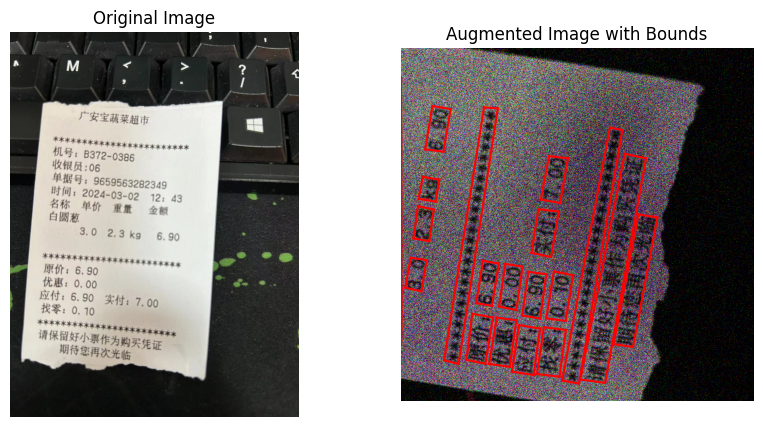

In [110]:
# Load and access JSON data correctly
base_path = "../code/data/chinese_receipt"
with open(f"{base_path}/ufo/train.json", 'r', encoding='utf-8') as file:
    data = json.load(file)
    
# Get the first image name and data
first_image = list(data['images'].items())[0]  # Get first image entry
image_name = first_image[0]  # Get image name
image_data = first_image[1]  # Get image data
words = image_data['words'].values() # Get words data

image_size=2048
crop_size=1024
ignore_under_threshold = 10
drop_under_threshold = 1
color_jitter = True
normalize = True

vertices, labels = [], []

for word in words:
    num_pts = np.array(word['points']).shape[0]
    if num_pts > 4:
        continue
    vertices.append(np.array(word['points']).flatten())
    labels.append(1)
    
vertices, labels = np.array(vertices, dtype=np.float32), np.array(labels, dtype=np.int64)
vertices, labels = filter_vertices(
    vertices,
    labels,
    ignore_under=ignore_under_threshold,
    drop_under=drop_under_threshold
)

image_path = f'{base_path}/img/train/{image_name}'
image = Image.open(image_path)
original = image.copy()
image, vertices = resize_img(image, vertices, image_size)
image, vertices = adjust_height(image, vertices)
# image, vertices = perspective_augmentaiton(image, vertices)
image, vertices = rotate_img(image, vertices)
image, vertices = crop_img(image, vertices, labels, crop_size)

# albumentation의 keypoint 기능을 사용하기 위해 format을 변환
# vertices = clip_vertices(vertices.reshape(-1, 2), image.width, image.height)
# vertices = vertices.reshape(-1, 2)
  
if image.mode != 'RGB':
    image = image.convert('RGB')
    
image = np.array(image)
# keypoint에 영향을 주지 않는 변환들
pixel_transforms = []

if color_jitter:
    pixel_transforms.append(A.ColorJitter())
if normalize:
    pixel_transforms.append(A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))

# Custom Aug
# pixel_transforms.append(
#     RectangleShadowTransform(
#         opacity_range=(0.7, 0.9),
#         width_range=(0.25, 0.5),
#         height_range=(0.25, 0.5),
#         p=0.7
#     )
# )
pixel_transforms.append(A.MotionBlur(blur_limit=21, p=0.5))
pixel_transforms.append(A.GaussNoise(var_limit=(0.5, 0.05), p=1))
pixel_composer = A.Compose(pixel_transforms)
image = pixel_composer(image=image)['image']

# keypoint 변환이 필요한 tranform들 (ex: RandomRotation90)
geometric_transforms = [
    A.RandomRotate90()
    # A.Perspective(scale=(0.05, 0.1), keep_size=True, always_apply=False, p=0.5),
    # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    # A.OpticalDistortion(distort_limit=0.1, shift_limit=0.1, p=0.5),
]

if geometric_transforms:
    # albumentation의 keypoint 기능을 사용하기 위해 format을 변환
    height, width = image.shape[:2]
    vertices = clip_vertices(vertices.reshape(-1, 2), width, height)
    geometric_composer = A.Compose(
        geometric_transforms,
        keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)  # Keep all keypoints
    )
    augmented = geometric_composer(image=image, keypoints=vertices)
    image, vertices = augmented['image'], np.array(augmented['keypoints'], dtype=np.float32).reshape(-1, 8)

    
# funcs.append(A.RandomRotate90())

# funcs.append(A.ElasticTransform(alpha=1000, sigma=50, p=1.0))  # 적절한 alpha와 sigma 값으로 조정

# funcs.append(A.GridDistortion(num_steps=5, distort_limit=0.015, p=1))

# funcs.append(A.OpticalDistortion(distort_limit=0.1, shift_limit=0.1, p=1))

# funcs.append(A.MotionBlur(blur_limit=21, p=1))

# funcs.append(A.GaussianBlur(blur_limit=(7, 21), sigma_limit=(1, 10), p=1))

# funcs.append(A.GaussNoise(var_limit=(0.01, 0.05), p=1))  # 가우시안 노이즈 추가
# funcs.append(A.MultiplicativeNoise(multiplier=(0.9, 1.5), p=0.5))  # 곱셈 노이즈 추가


word_bboxes = np.reshape(vertices, (-1, 4, 2))
roi_mask = generate_roi_mask(image, vertices, labels)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Original Image')
axs[0].imshow(original)
axs[0].axis('off')

axs[1].set_title('Augmented Image with Bounds')
for bound in vertices:
    axs[1].plot([bound[0], bound[2]], [bound[1], bound[3]], 'r')  # 첫 번째 선
    axs[1].plot([bound[2], bound[4]], [bound[3], bound[5]], 'r')  # 두 번째 선
    axs[1].plot([bound[4], bound[6]], [bound[5], bound[7]], 'r')  # 세 번째 선
    axs[1].plot([bound[6], bound[0]], [bound[7], bound[1]], 'r')  # 네 번째 선
axs[1].imshow(image)
axs[1].axis('off')

plt.show()